In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import seaborn as sns


In [2]:
# Load Data
prices = pd.read_csv("adjusted_monthly_close_prices_by_company_1997_2024.csv", parse_dates=["Date"])
indicators = pd.read_csv("tech_indicator_for_stock_1997_2024.csv", parse_dates=["Date"])

In [3]:
# Melt and merge
melted = prices.melt(id_vars='Date', var_name='Ticker', value_name='AdjClose')
merged = melted.merge(indicators, on=["Date", "Ticker"], how="inner")

# Filter sectors
sectors = ['Consumer Staples', 'Consumer Discretionary', 'Technology', 'Industrial']
merged = merged[merged['Sector'].isin(sectors)]

# Sort and calculate returns & volatility at individual stock level
merged = merged.sort_values(by=["Ticker", "Date"])
merged["Return"] = merged.groupby("Ticker")["AdjClose"].transform(lambda x: x.pct_change())
merged["Volatility"] = merged.groupby("Ticker")["Return"].transform(lambda x: x.rolling(window=6).std())

# Aggregate by sector and date
sector_monthly = merged.groupby(["Date", "Sector"]).agg({
    "Return": "mean",       # average return across stocks in sector
    "Volatility": "mean"    # average volatility across stocks in sector
}).reset_index()


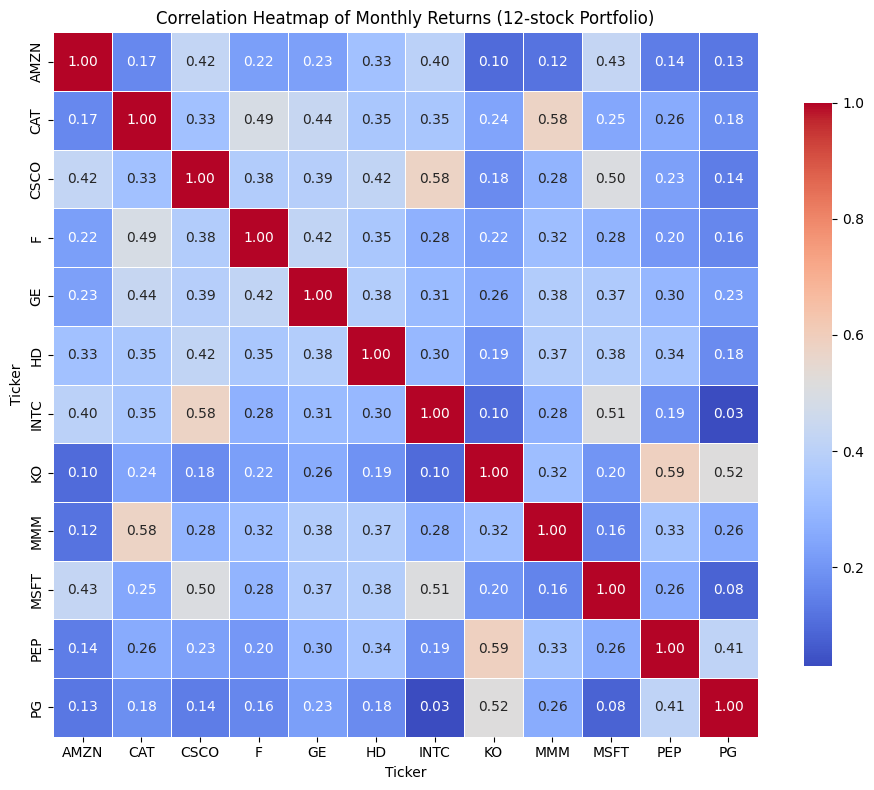

In [6]:
return_matrix = merged.pivot(index='Date', columns='Ticker', values='Return')

# Step 2: Compute the correlation matrix
correlation_matrix = return_matrix.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title("Correlation Heatmap of Monthly Returns (12-stock Portfolio)")
plt.tight_layout()
plt.show()

In [8]:
# Set Date as datetime index
sector_monthly["Date"] = pd.to_datetime(sector_monthly["Date"])
df_subset = sector_monthly.set_index("Date")

#Define Recession periods
recessions = [
    ("2001-03-01", "2001-11-01"), #Dot-com Bubble
    ("2007-12-01", "2009-06-01"), #Global Financial Crisis
    ("2020-02-01", "2020-04-01")  #COVID-19 Pandemic
]
recession_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in recessions]

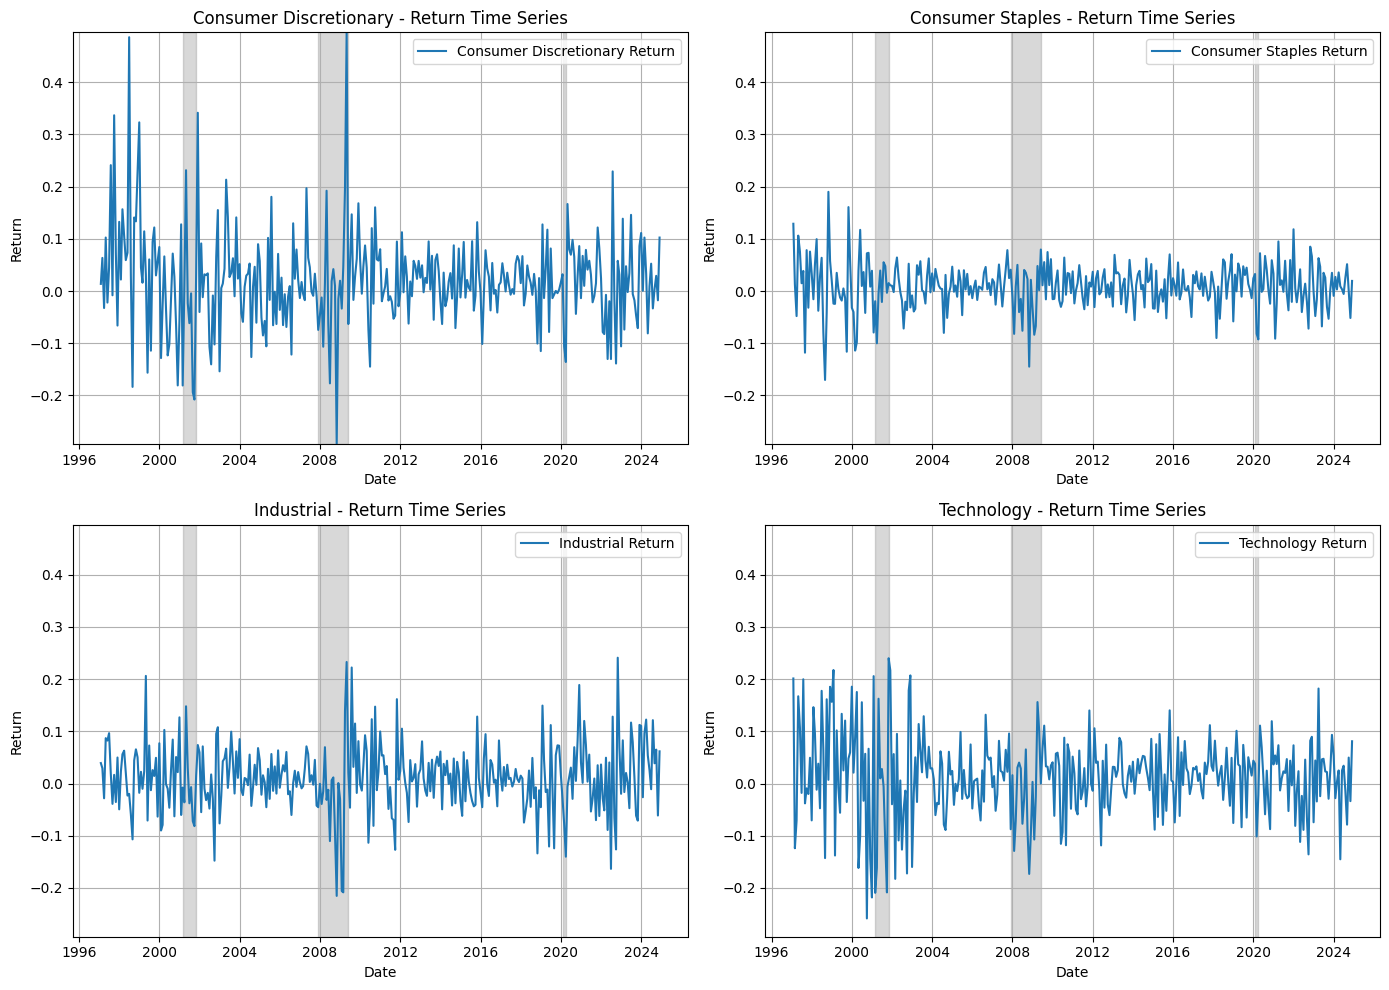

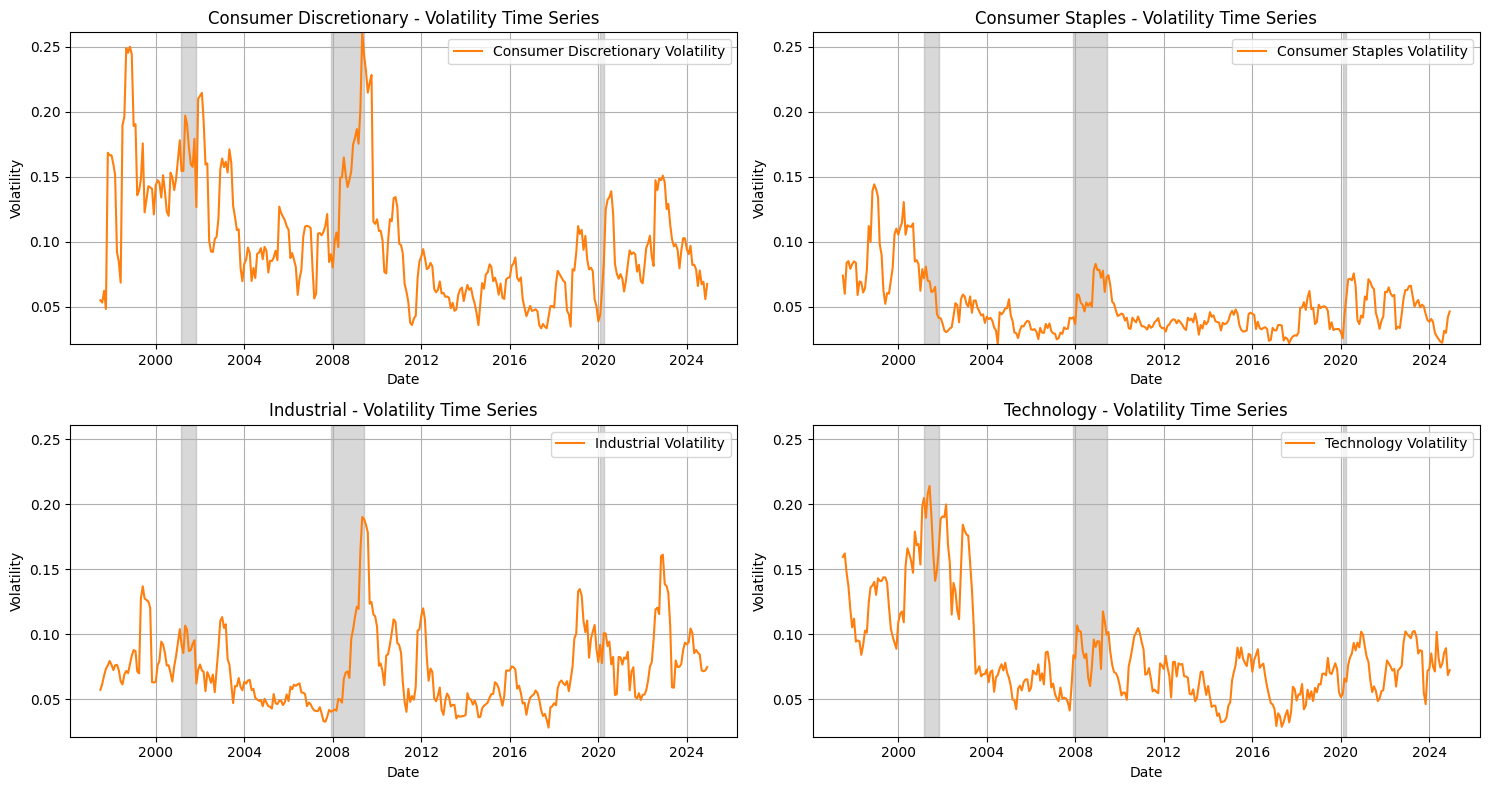

In [9]:
#Plot
sectors = df_subset['Sector'].unique()
return_min = df_subset['Return'].min()
return_max = df_subset['Return'].max()
volatility_min = df_subset['Volatility'].min()
volatility_max = df_subset['Volatility'].max()

#Returns
plt.figure(figsize=(14, 10))

for i, sector in enumerate(sectors, 1):
    plt.subplot(2, 2, i)
    sector_data = df_subset[df_subset['Sector'] == sector]

    plt.plot(sector_data.index, sector_data['Return'], label=f'{sector} Return', color='tab:blue')
    plt.title(f'{sector} - Return Time Series')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    for start_date, end_date in recession_dates:
        plt.axvspan(start_date, end_date, color='gray', alpha=0.3)
    plt.ylim(return_min, return_max)

plt.tight_layout()
plt.show()

#Volatility
plt.figure(figsize=(15, 8))

for i, sector in enumerate(sectors, 1):
    plt.subplot(2, 2, i)
    sector_data = df_subset[df_subset['Sector'] == sector]

    # Plot Volatility
    plt.plot(sector_data.index, sector_data['Volatility'], label=f'{sector} Volatility', color='tab:orange')
    plt.title(f'{sector} - Volatility Time Series')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.legend()
    for start_date, end_date in recession_dates:
        plt.axvspan(start_date, end_date, color='gray', alpha=0.3)
    plt.ylim(volatility_min, volatility_max)

# Adjust layout
plt.tight_layout()
plt.show()

These two sets of time series plots represent monthly returns and volatility for four sectors—Consumer Discretionary, Consumer Staples, Industrial, and Technology—from 1997 through 2024. The shaded gray regions correspond to periods of U.S. economic recessions:
- ("2001-03-01", "2001-11-01"), #Dot-com Bubble
- ("2007-12-01", "2009-06-01"), #Global Financial Crisis
- ("2020-02-01", "2020-04-01")  #COVID-19 Pandemic.

**First Set: Return Time Series (monthly returns for a specific sector):**

- All sectors experience larger return fluctuations during recession periods, especially in 2008 and 2020.

- Consumer Discretionary and Technology:
    - More pronounced swings in returns, especially during the Dot-com bubble (~2000) and 2008 Financial Crisis.
    - Post-2008, return fluctuations appear somewhat more subdued.

- Consumer Staples: Relatively stable returns compared to other sectors, indicating it's more defensive (less sensitive to economic cycles).

- Industrial: Shows moderate fluctuations, more reactive during recessions than Consumer Staples but not as volatile as Consumer Discretionary or Technology.

**Second Set: Volatility Time Series (estimated return volatility):**

- All sectors show strong volatility spikes around the 2008 crisis and the COVID-19 pandemic in 2020.

- Consumer Discretionary: Shows the highest peak in volatility during 2008 (~0.225), reflecting high uncertainty.

- Consumer Staples: Consistently exhibits lower volatility, reinforcing its classification as a "defensive sector."

- Technology: High volatility during the Dot-com crash (2000–2002), again in 2008, and COVID-19.

- Industrial: Noticeable spikes in 2008 and 2020, with a few smaller volatility rises post-2020.

**Overall:**

- All sectors become more volatile during recessions, but the degree varies.

- Consumer Staples = Defensive: more stable returns and lower volatility.

- Consumer Discretionary & Technology = Cyclical: more sensitive to economic conditions.

- Volatility and return fluctuations appear generally lower across all sectors, except for notable events like COVID-19 and recent market uncertainty (2022–2024).



In [20]:
SP500 = pd.read_excel("S&P500 indexes.xlsx", parse_dates=["Date"])
SP500 = SP500.sort_values("Date")
spx = SP500.set_index("Date")["SPX"]

# Calculate monthly return
spx_return = spx.pct_change()

# Calculate 6-month rolling volatility (standard deviation of returns)
spx_rolling_volatility = spx_return.rolling(window=6).std()

# Combine into a DataFrame for inspection
spx_stats = pd.DataFrame({
    "SPX": spx,
    "Return": spx_return,
    "RollingVolatility": spx_rolling_volatility
})

spx_stats.head(10)

,SPX,Return,RollingVolatility
Date,,,
1997-01-01,737.01,NaN,NaN
1997-02-01,786.73,0.067462,NaN
1997-03-01,795.31,0.010906,NaN
1997-04-01,759.64,-0.044850,NaN
1997-05-01,798.53,0.051195,NaN
1997-06-01,846.36,0.059898,NaN
1997-07-01,891.03,0.052779,0.042854
1997-08-01,947.14,0.062972,0.042163
1997-09-01,927.58,-0.020652,0.047030


In [ ]:
# Pivot the data
df_subset = df_subset.reset_index()
returns_df = df_subset.pivot(index='Date', columns='Sector', values='Return')
vol_df = df_subset.pivot(index='Date', columns='Sector', values='Volatility')
returns_df['SPX'] = spx_stats['Return']
vol_df['SPX'] = spx_stats['RollingVolatility']

# Set SPX as benchmark
benchmark = returns_df['SPX']
rolling_avg_return = returns_df.rolling(window=12).mean()
rolling_volatility = returns_df.rolling(window=12).std()


#Rolling Beta function
def calc_rolling_beta(stock_returns, benchmark_returns, window=12):
    beta_series = pd.Series(index=stock_returns.index, dtype=float)

    for i in range(window, len(stock_returns)):
        y = stock_returns.iloc[i-window:i]
        x = benchmark_returns.iloc[i-window:i]
        if x.isnull().any() or y.isnull().any():
            continue
        model = OLS(y, add_constant(x)).fit()
        beta_series.iloc[i] = model.params[1]

    return beta_series

# Apply to each sector (except benchmark)
rolling_beta = pd.DataFrame(index=returns_df.index)
for sector in returns_df.columns:
    if sector != 'SPX':  # skip benchmark
        rolling_beta[sector] = calc_rolling_beta(returns_df[sector], benchmark)

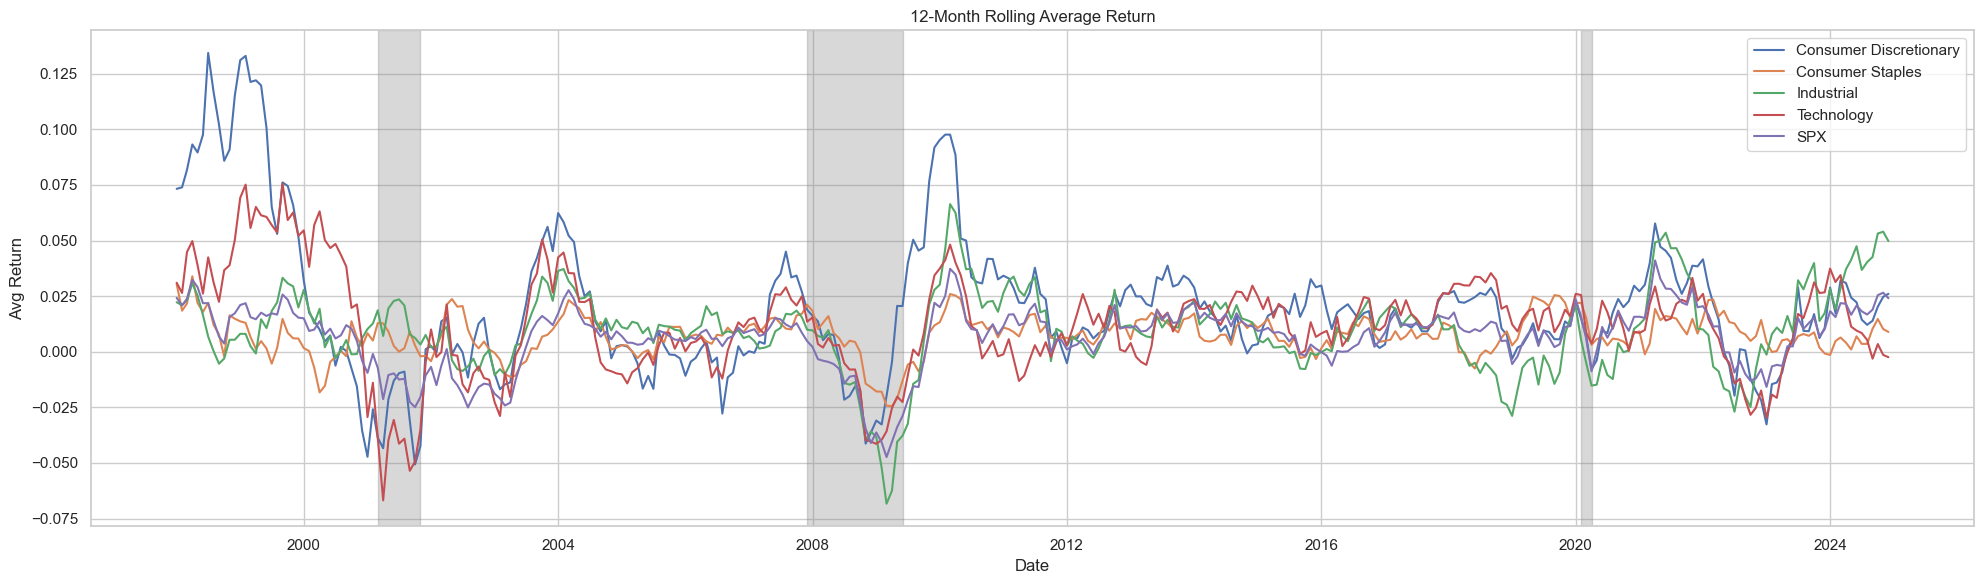

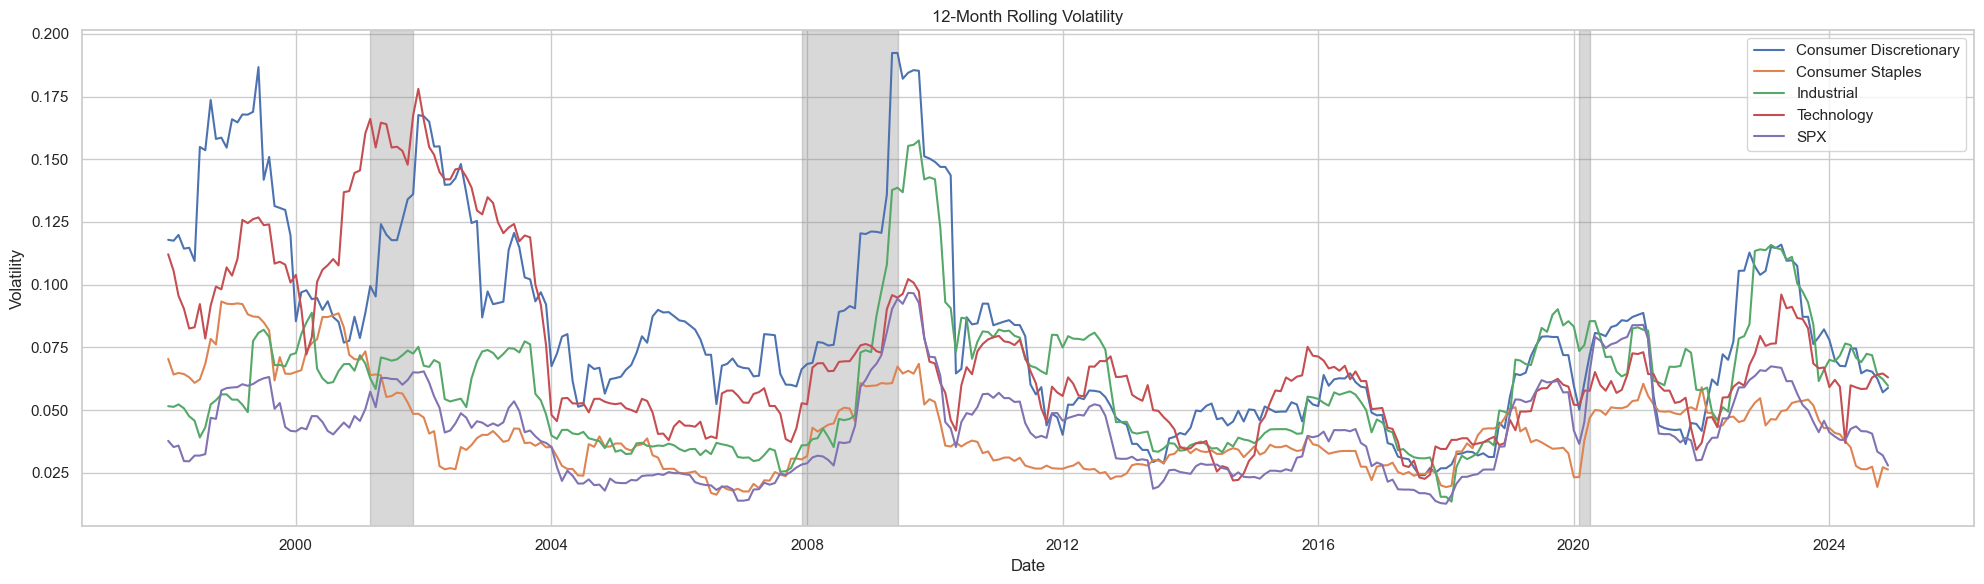

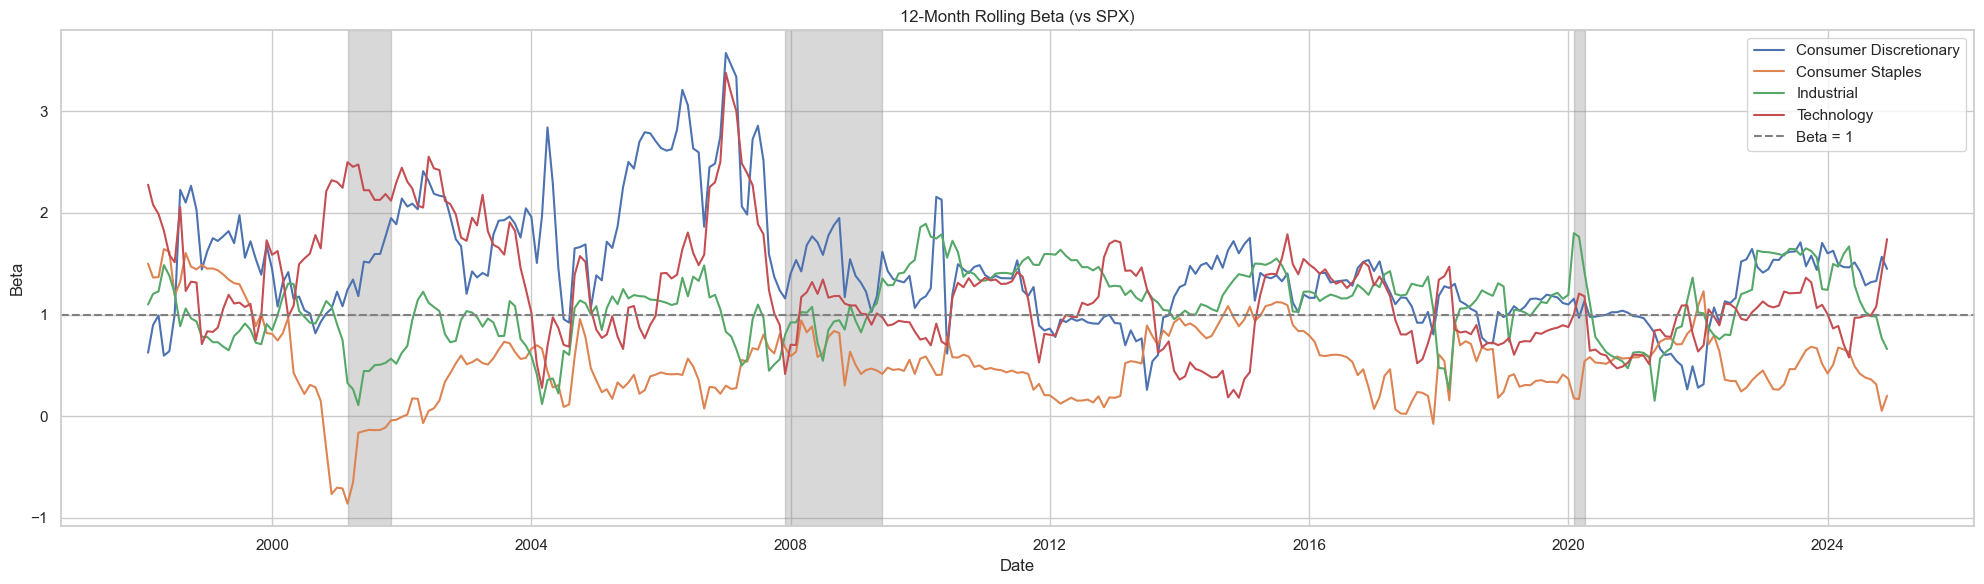

In [24]:
# Plot
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20, 6)

# 1. Rolling Average Return
plt.figure()
for sector in returns_df.columns:
    plt.plot(rolling_avg_return.index, rolling_avg_return[sector], label=sector)
plt.title('12-Month Rolling Average Return')
plt.ylabel('Avg Return')
plt.xlabel('Date')
plt.legend()
for start_date, end_date in recession_dates:
    plt.axvspan(start_date, end_date, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Rolling Volatility
plt.figure()
for sector in vol_df.columns:
    plt.plot(rolling_volatility.index, rolling_volatility[sector], label=sector)
plt.title('12-Month Rolling Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend()
for start_date, end_date in recession_dates:
    plt.axvspan(start_date, end_date, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Rolling Beta (vs Consumer Staples)
plt.figure()
for sector in rolling_beta.columns:
    plt.plot(rolling_beta.index, rolling_beta[sector], label=sector)
plt.title('12-Month Rolling Beta (vs SPX)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.axhline(1.0, color='gray', linestyle='--', label='Beta = 1')
plt.legend()
for start_date, end_date in recession_dates:
    plt.axvspan(start_date, end_date, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()


**12-Month Rolling Average Return**

- $R_{rolling} = \frac{1}{t} \sum_{i=1}^t r_i$

- All sectors show cyclical behavior, reflecting market and economic cycles.

- Technology (red) tends to have higher peaks and deeper troughs than the others, indicating more aggressive swings in performance.

- Consumer Staples (orange) remains more stable with lower volatility and smaller swings — typical of defensive sectors.

- Around 2008 and 2020 (financial crisis and COVID-19), all sectors show sharp drops and rebounds.


**12-Month Rolling Volatility**

- $\sigma_{rolling} = \sqrt{\frac{1}{t-1} \sum_{i=1}^t (r_i - \bar{r})^2}$

- Volatility spikes are visible during major market events (e.g., dot-com bubble, financial crisis, COVID-19).

- Consumer Discretionary (blue) and Technology (red) often show higher volatility.

- Consumer Staples consistently displays the lowest volatility, reinforcing its role as a defensive sector.


**12-Month Rolling Beta (vs. Consumer Staples)**

- We define the rolling beta using an Ordinary Least Squares (OLS) regression:

$r_{\text{stock}, t} = \alpha + \beta \cdot r_{\text{benchmark}, t} + \varepsilon_t$ ---> $\beta = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2} = \frac{Cov(x,y)}{Var(x)}$, where $x = r_{\text{benchark}}$ and $y = r_{\text{stock}}$

- A Beta > 1 indicates the sector is more volatile than Consumer Staples; Beta < 1 implies it’s less volatile.

- Consumer Discretionary (blue) often rises well above 1, showing it’s more sensitive to market changes. During the Big Recession and COVID-19: consumer Discretionary stocks were twice as volatile compared to Consumer Staples -> People cut back hard on non-essentials.

- Technology (green) shows periods of both high and low Beta, indicating that its relationship with the benchmark changes over time. Early in COVID, tech stocks briefly became negatively correlated with Staples — probably because tech became a "safe haven" (Zoom, remote work, etc.)

- Industrial (orange) usually stays close to 1, suggesting its risk is more in line with Consumer Staples on average.

- All sectors experience large swings in Beta during crisis periods, especially 2008 and 2020, which shows market correlation breaks during stress.


**Overall**

- Consumer Staples is the most stable, lowest risk sector.

- Technology offers higher return potential but with much more risk and volatility.

- Consumer Discretionary shows similar high volatility and return swings, behaving more like a cyclical sector.

- Beta analysis highlights how sector sensitivity to market movements changes over time, especially during crises.